In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import fmin_cg, minimize, least_squares
import tqdm
from itertools import product
from matplotlib import rc

In [2]:
alpha, beta = np.random.uniform(size=2)
print('alpha:', alpha)
print('beta:', beta)

alpha: 0.17209552415130125
beta: 0.4335825338485265


In [3]:
def linear(X, a, b):
    return X * a + b

In [4]:
def rational(X, a, b):
    return a / (1 + b * X)

In [5]:
X = np.arange(0, 1.01, 0.01)
delta = np.random.normal(size=X.shape)
y_k = alpha * X + beta
y = alpha * X + beta + delta
opt_data = pd.DataFrame(np.vstack([X, y_k, y]).T, columns=['X', 'y_k', 'y'])

In [6]:
opt_data

,X,y_k,y
0,0.00,0.433583,-0.193581
1,0.01,0.435303,-0.940153
2,0.02,0.437024,2.227349
3,0.03,0.438745,-0.105980
4,0.04,0.440466,0.386668
...,...,...,...
96,0.96,0.598794,-0.400454
97,0.97,0.600515,0.182431
98,0.98,0.602236,1.132173
99,0.99,0.603957,0.622075


In [7]:
def loss(func, X, a, b, y_true, a_bounds=(0, 1), b_bounds=(0, 1), apply_bounds=False, ):
    if apply_bounds:
        if a < a_bounds[0] or a > a_bounds[1]:
            return 10 ** 10
        if b < b_bounds[0] or b > b_bounds[1]:
            return 10 ** 10
    approx = func(X, a, b)
    return np.sum((approx - y_true) ** 2)

In [8]:
def golden_section(func, left, right, epsilon=0.001):
    delta = (3 - np.sqrt(5)) / 2
    x1, x2 = left + delta * (right - left), right - delta * (right - left)
    f_x1, f_x2 = map(func, [x1, x2])
    iters = 2
    while (right - left) > epsilon:
        if f_x1 <= f_x2:
            right = x2
            x2 = x1
            f_x2 = f_x1
            calc_x2 = False
        else:
            left = x1
            x1 = x2
            f_x1 = f_x2
            calc_x2 = True
        if calc_x2:
            x2 = right - delta * (right - left)
            f_x2 = func(x2)
        else:
            x1 = left + delta * (right - left)
            f_x1 = func(x1)
        iters += 1
    min_f = func((right - left) / 2 + right)
    return {"min": (right - left) / 2 + right, "func_min": min_f, "iterations": iters}

In [9]:
def exhaustivesearch(func, X, y_true, a_bounds=(0, 1), b_bounds=(0, 1), epsilon=0.001):
    a_values = np.arange(a_bounds[0], a_bounds[1] + epsilon, epsilon)
    b_values = np.arange(b_bounds[0], b_bounds[1] + epsilon, epsilon)

    min_loss = 10 ** 10
    min_args = None
    for a in a_values:
        for b in b_values:
            loss_value = loss(func, X, a, b, y_true)
            if loss_value < min_loss:
                min_args = {"a": a, "b": b}
                min_loss = loss_value
    return {"loss": min_loss, "args": min_args, "iterations": a_values.shape[0] * b_values.shape[0]}


In [10]:
def gauss(func, X, y_true, a_bounds=(0, 1), b_bounds=(0, 1), epsilon=0.001):
    a, b = map(np.mean, [a_bounds, b_bounds])
    a_prev, b_prev = a_bounds[0], b_bounds[0]
    loss_prev = loss(func, X, a, b, y_true)

    min_loss = 10 ** 10
    iters = 1
    loss_values = []

    while (
        scipy.spatial.distance.euclidean([a_prev, b_prev], [a, b]) > epsilon and np.abs(loss_prev - min_loss) > epsilon
    ):
        for opt_var in ["a", "b"]:
            if opt_var == "a":
                aux_func = lambda x: loss(func, X, a=x, b=b, y_true=y_true)
                opt = golden_section(aux_func, a_bounds[0], b_bounds[1], epsilon=epsilon)
                a_prev = a
                a = opt["min"]
            else:
                aux_func = lambda x: loss(func, X, a=a, b=x, y_true=y_true)
                opt = golden_section(aux_func, b_bounds[0], b_bounds[1], epsilon=epsilon)
                b_prev = b
                b = opt["min"]

            iters += opt["iterations"]
            min_loss = opt["func_min"]
            loss_values.append(min_loss)
    return {
        "loss": min_loss,
        "args": {"a": a, "b": b},
        "iterations": iters,
        "loss_values": loss_values
    }

In [11]:
def nelder_mead(func, X, y_true, a_bounds=(0, 1), b_bounds=(0, 1), epsilon=0.001):
    opt_func = lambda x: loss(func, X=X, a=x[0], b=x[1], y_true=y, a_bounds=a_bounds, b_bounds=b_bounds, apply_bounds=True)
    a0, b0 = map(np.mean, [a_bounds, b_bounds])
    result = scipy.optimize.minimize(
        opt_func, x0=[a0, b0], method="Nelder-Mead", options={"xatol": epsilon, "fatol": epsilon}
    )
    return {"loss": result.fun, "args": {"a": result.x[0], "b": result.x[1]}, "iterations": result.nfev}

In [12]:
#data for algorithms
data_opt = []
for method, approx_func in tqdm.tqdm(
    product(["exhaustivesearch", "gauss", "nelder_mead"], ["linear", "rational"]),total=6):
    opt_res = eval(method)(eval(approx_func), X, y, a_bounds=(-2, 2), b_bounds=(-2, 2))
    data_opt.append(
        {
            "method": method,
            "approx_func": approx_func,
            "loss": opt_res["loss"],
            "a": opt_res["args"]["a"],
            "b": opt_res["args"]["b"],
            "iterations": opt_res["iterations"],
        }
    )

approx = pd.DataFrame(data_opt)

 17%|█▋        | 1/6 [02:16<11:20, 136.08s/it]/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
100%|██████████| 6/6 [05:03<00:00, 50.66s/it] 


In [13]:
approx

,method,approx_func,loss,a,b,iterations
0,exhaustivesearch,linear,101.641430,0.554000,0.162000,16008001
1,exhaustivesearch,rational,100.926980,0.234000,-0.754000,16008001
2,gauss,linear,101.641494,0.555122,0.161920,641
3,gauss,rational,100.930309,0.239652,-0.745084,641
4,nelder_mead,linear,101.641424,0.553067,0.162239,110
5,nelder_mead,rational,100.926954,0.234357,-0.753929,112


In [14]:
def loss_(func, X, a, b, y_true, reduction=True):
    approx = func(X, a, b)
    if reduction:
        return np.sum((approx - y_true) ** 2)
    else:
        return approx - y_true

In [15]:
def grad_linear(X, a, b):
    return X, np.full_like(X, 1)

In [16]:
def grad_rational(X, a, b):
    return 1 / (1 + b * X), -a * X / ((1 + b * X) ** 2)

In [17]:
def grad_loss(func, X, a, b, y_true):
    approx = func(X, a, b)
    return 2 * (approx - y_true)

In [18]:
def gd(func_name, X, y_true, a_init, b_init, lr=1e-4, epsilon=1e-4, max_epochs=1e5):
    a, b = a_init, b_init
    losses = []
    n_iters = 0
    while True:
        losses.append(loss_(eval(func_name), X, a, b, y_true))
        grad_lf = grad_loss(eval(func_name), X, a, b, y_true)
        grad_fa, grad_fb = eval(f"grad_{func_name}")(X, a, b)
        grad_a, grad_b = np.sum(grad_lf * grad_fa), np.sum(grad_lf * grad_fb)
        a -= grad_a * lr
        b -= grad_b * lr
        n_iters += 1
        if (np.abs(grad_a) < epsilon and np.abs(grad_b) < epsilon) or n_iters > max_epochs:
            break
    return {"loss": losses[-1], "args": {"a": a, "b": b}, "iterations": n_iters}

In [19]:
def conj_gd(func_name, X, y_true, a_init, b_init, lr=1e-4, epsilon=1e-4, max_epochs=1e5):
    def func(x):
        return loss_(eval(func_name), X, a=x[0], b=x[1], y_true=y_true)

    def grad_func(x):
        grad_lf = grad_loss(eval(func_name), X, a=x[0], b=x[1], y_true=y_true)
        grad_fa, grad_fb = eval(f"grad_{func_name}")(X, a=x[0], b=x[1])
        grad_a, grad_b = np.sum(grad_lf * grad_fa), np.sum(grad_lf * grad_fb)
        return np.asarray((grad_a, grad_b))

    result = fmin_cg(
        func, x0=np.asarray([a_init, b_init]), fprime=grad_func, gtol=epsilon, maxiter=max_epochs, full_output=True
    )
    return {"loss": result[1], "args": {"a": result[0][0], "b": result[0][1]}, "iterations": result[2]}


In [20]:
def newton(func_name, X, y_true, a_init, b_init, lr=1e-4, epsilon=1e-4, max_epochs=1e5):
    def func(x):
        return loss_(eval(func_name), X, a=x[0], b=x[1], y_true=y_true)

    def grad_func(x):
        grad_lf = grad_loss(eval(func_name), X, a=x[0], b=x[1], y_true=y_true)
        grad_fa, grad_fb = eval(f"grad_{func_name}")(X, a=x[0], b=x[1])
        grad_a, grad_b = np.sum(grad_lf * grad_fa), np.sum(grad_lf * grad_fb)
        return np.asarray((grad_a, grad_b))

    result = minimize(
        func, x0=np.asarray([a_init, b_init]), jac=grad_func, options={"xtol": epsilon, "maxiter": max_epochs}
    )

    return {"loss": result.fun, "args": {"a": result.x[0], "b": result.x[1]}, "iterations": result.nfev}


In [21]:
def lm(func_name, X, y_true, a_init, b_init, lr=1e-4, epsilon=1e-4, max_epochs=1e5):
    def func(x):
        return loss_(eval(func_name), X, a=x[0], b=x[1], y_true=y_true, reduction=False)

    def grad_func(x):
        grad_fa, grad_fb = eval(f"grad_{func_name}")(X, a=x[0], b=x[1])
        return np.vstack([grad_fa, grad_fb]).T

    result = least_squares(
        func, x0=np.asarray([a_init, b_init]), jac=grad_func, method="lm", gtol=epsilon, max_nfev=int(max_epochs)
    )
    return {"loss": result.cost * 2, "args": {"a": result.x[0], "b": result.x[1]}, "iterations": result.nfev}


In [22]:
a_init, b_init = 0, 0
data_opt = []
for method, func_name in tqdm.tqdm(
    product(["gd", "conj_gd", "newton", "lm"], ["linear", "rational"]),
    total=8):
    opt_res = eval(method)(
        func_name, X, y, a_init, b_init, lr=1e-4, max_epochs=1e5
        )
    data_opt.append(
        {
            "method": method,
            "approx_func": func_name,
            "loss": opt_res["loss"],
            "a": opt_res["args"]["a"],
            "b": opt_res["args"]["b"],
            "iterations": opt_res["iterations"],
        }
    )
data_opt = pd.DataFrame(data_opt)
approx= approx.append(data_opt)

 25%|██▌       | 2/8 [00:00<00:02,  2.88it/s]/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: OptimizeWarning: Unknown solver options: xtol
  if sys.path[0] == '':
100%|██████████| 8/8 [00:00<00:00, 12.76it/s]

Optimization terminated successfully.
         Current function value: 101.641423
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 100.926951
         Iterations: 9
         Function evaluations: 27
         Gradient evaluations: 27


In [23]:
approx

,method,approx_func,loss,a,b,iterations
0,exhaustivesearch,linear,101.641430,0.554000,0.162000,16008001
1,exhaustivesearch,rational,100.926980,0.234000,-0.754000,16008001
2,gauss,linear,101.641494,0.555122,0.161920,641
3,gauss,rational,100.930309,0.239652,-0.745084,641
4,nelder_mead,linear,101.641424,0.553067,0.162239,110
5,nelder_mead,rational,100.926954,0.234357,-0.753929,112
0,gd,linear,101.641423,0.553262,0.162212,7972
1,gd,rational,100.926951,0.234179,-0.754165,3416
2,conj_gd,linear,101.641423,0.553269,0.162208,5
3,conj_gd,rational,100.926951,0.234178,-0.754167,27


In [24]:
plt.rcParams["figure.figsize"] = (10, 6)
rc('font', family='serif', serif='Times New Roman')
Methods = {'exhaustivesearch': 'Exhaustive Search',
           'gauss': 'Gauss', 
           'nelder_mead': 'Nelder-Mead',
           'gd': 'Gradient Descent',
           'conj_gd': 'Conjugate Gradient Descent',
           'newton': 'Newtons',
           'lm': 'Levenberg-Marquardt'}

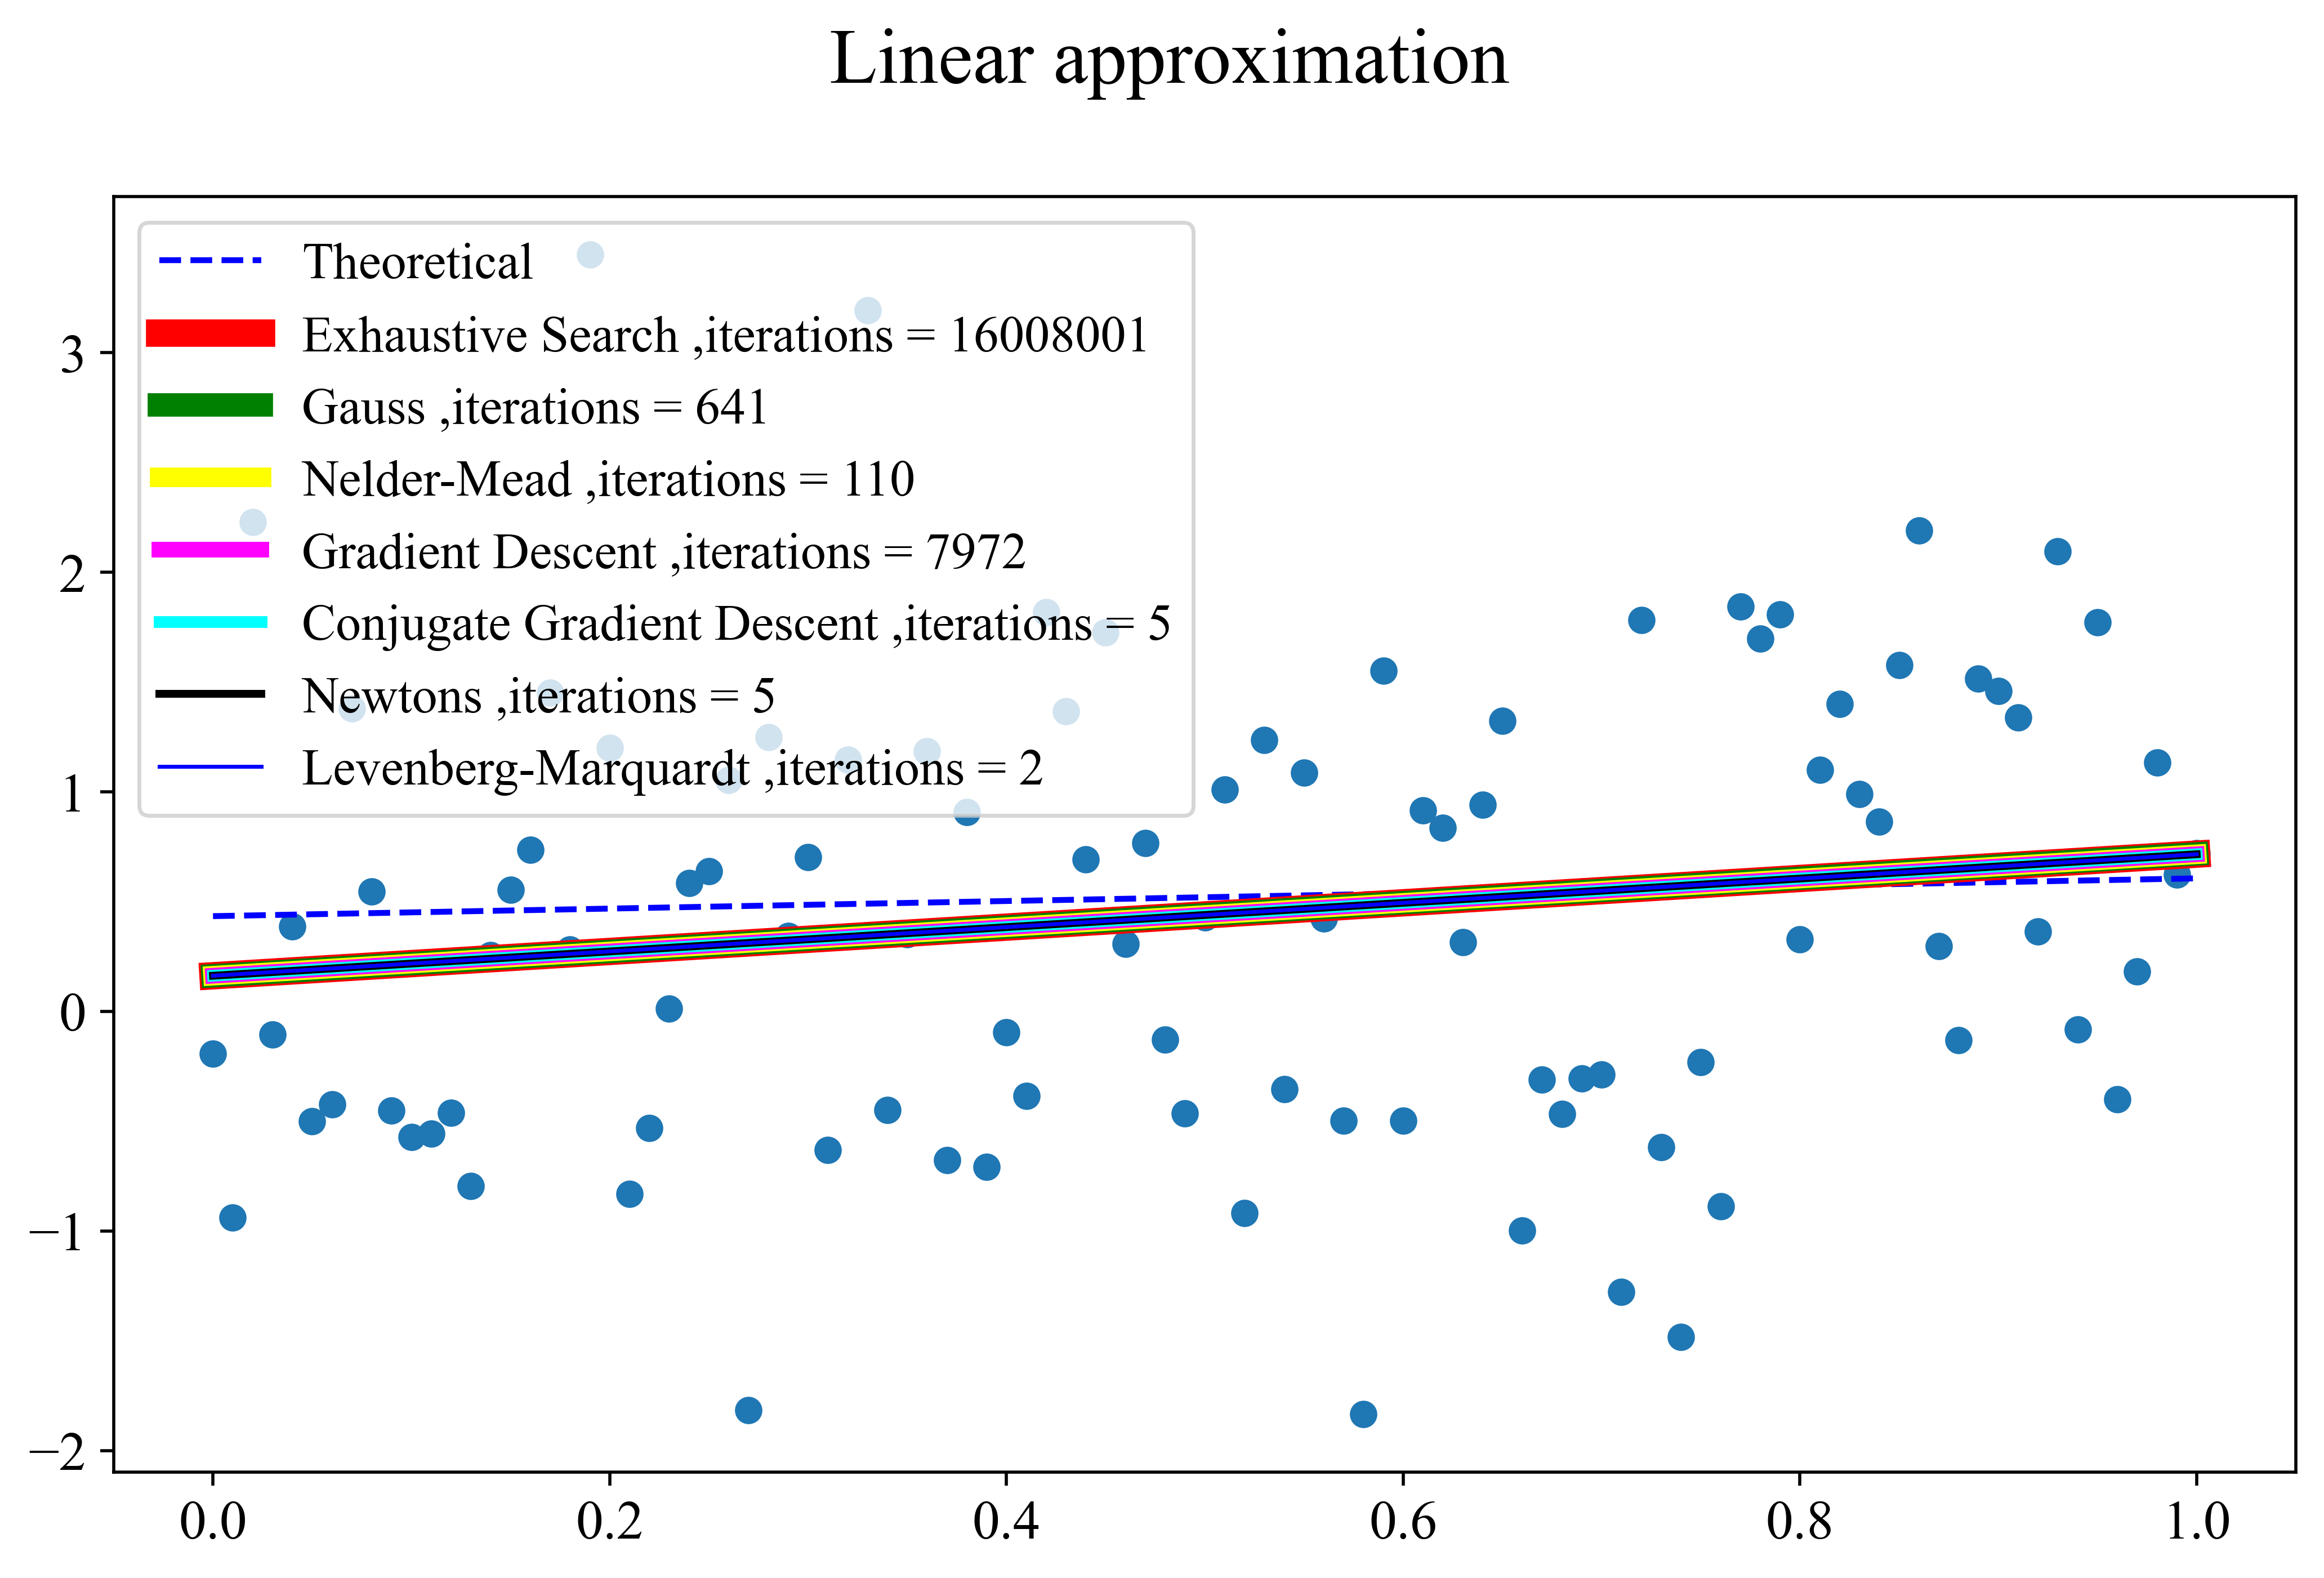

In [30]:
plt.figure(dpi=500)
plt.scatter(opt_data['X'], opt_data['y'])
plt.plot(opt_data['X'], opt_data['y_k'], c='blue', label=f'Theoretical',linestyle = '--')
for method, color,linewidth in zip(['exhaustivesearch', 'gauss', 'nelder_mead', 'gd', 'conj_gd', 'newton', 'lm'],
                         ['red', 'green', 'yellow', 'magenta', 'cyan','black','blue'],[7,6,5,4,3,2,1]):
    row = approx[(approx['method'] == method) & (approx['approx_func'] == 'linear')]
    a, b = row['a'].values[0], row['b'].values[0]
    y_pred = linear(opt_data['X'], a, b)
    iters = row['iterations'].values[0]
    plt.plot(opt_data['X'], y_pred, c=color, label=f'{Methods[method]} ,iterations = {iters}',linewidth=linewidth)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best',fontsize=13)
plt.suptitle('Linear approximation', fontsize=20)
plt.savefig(fname='Linear approximation.png', format='png')

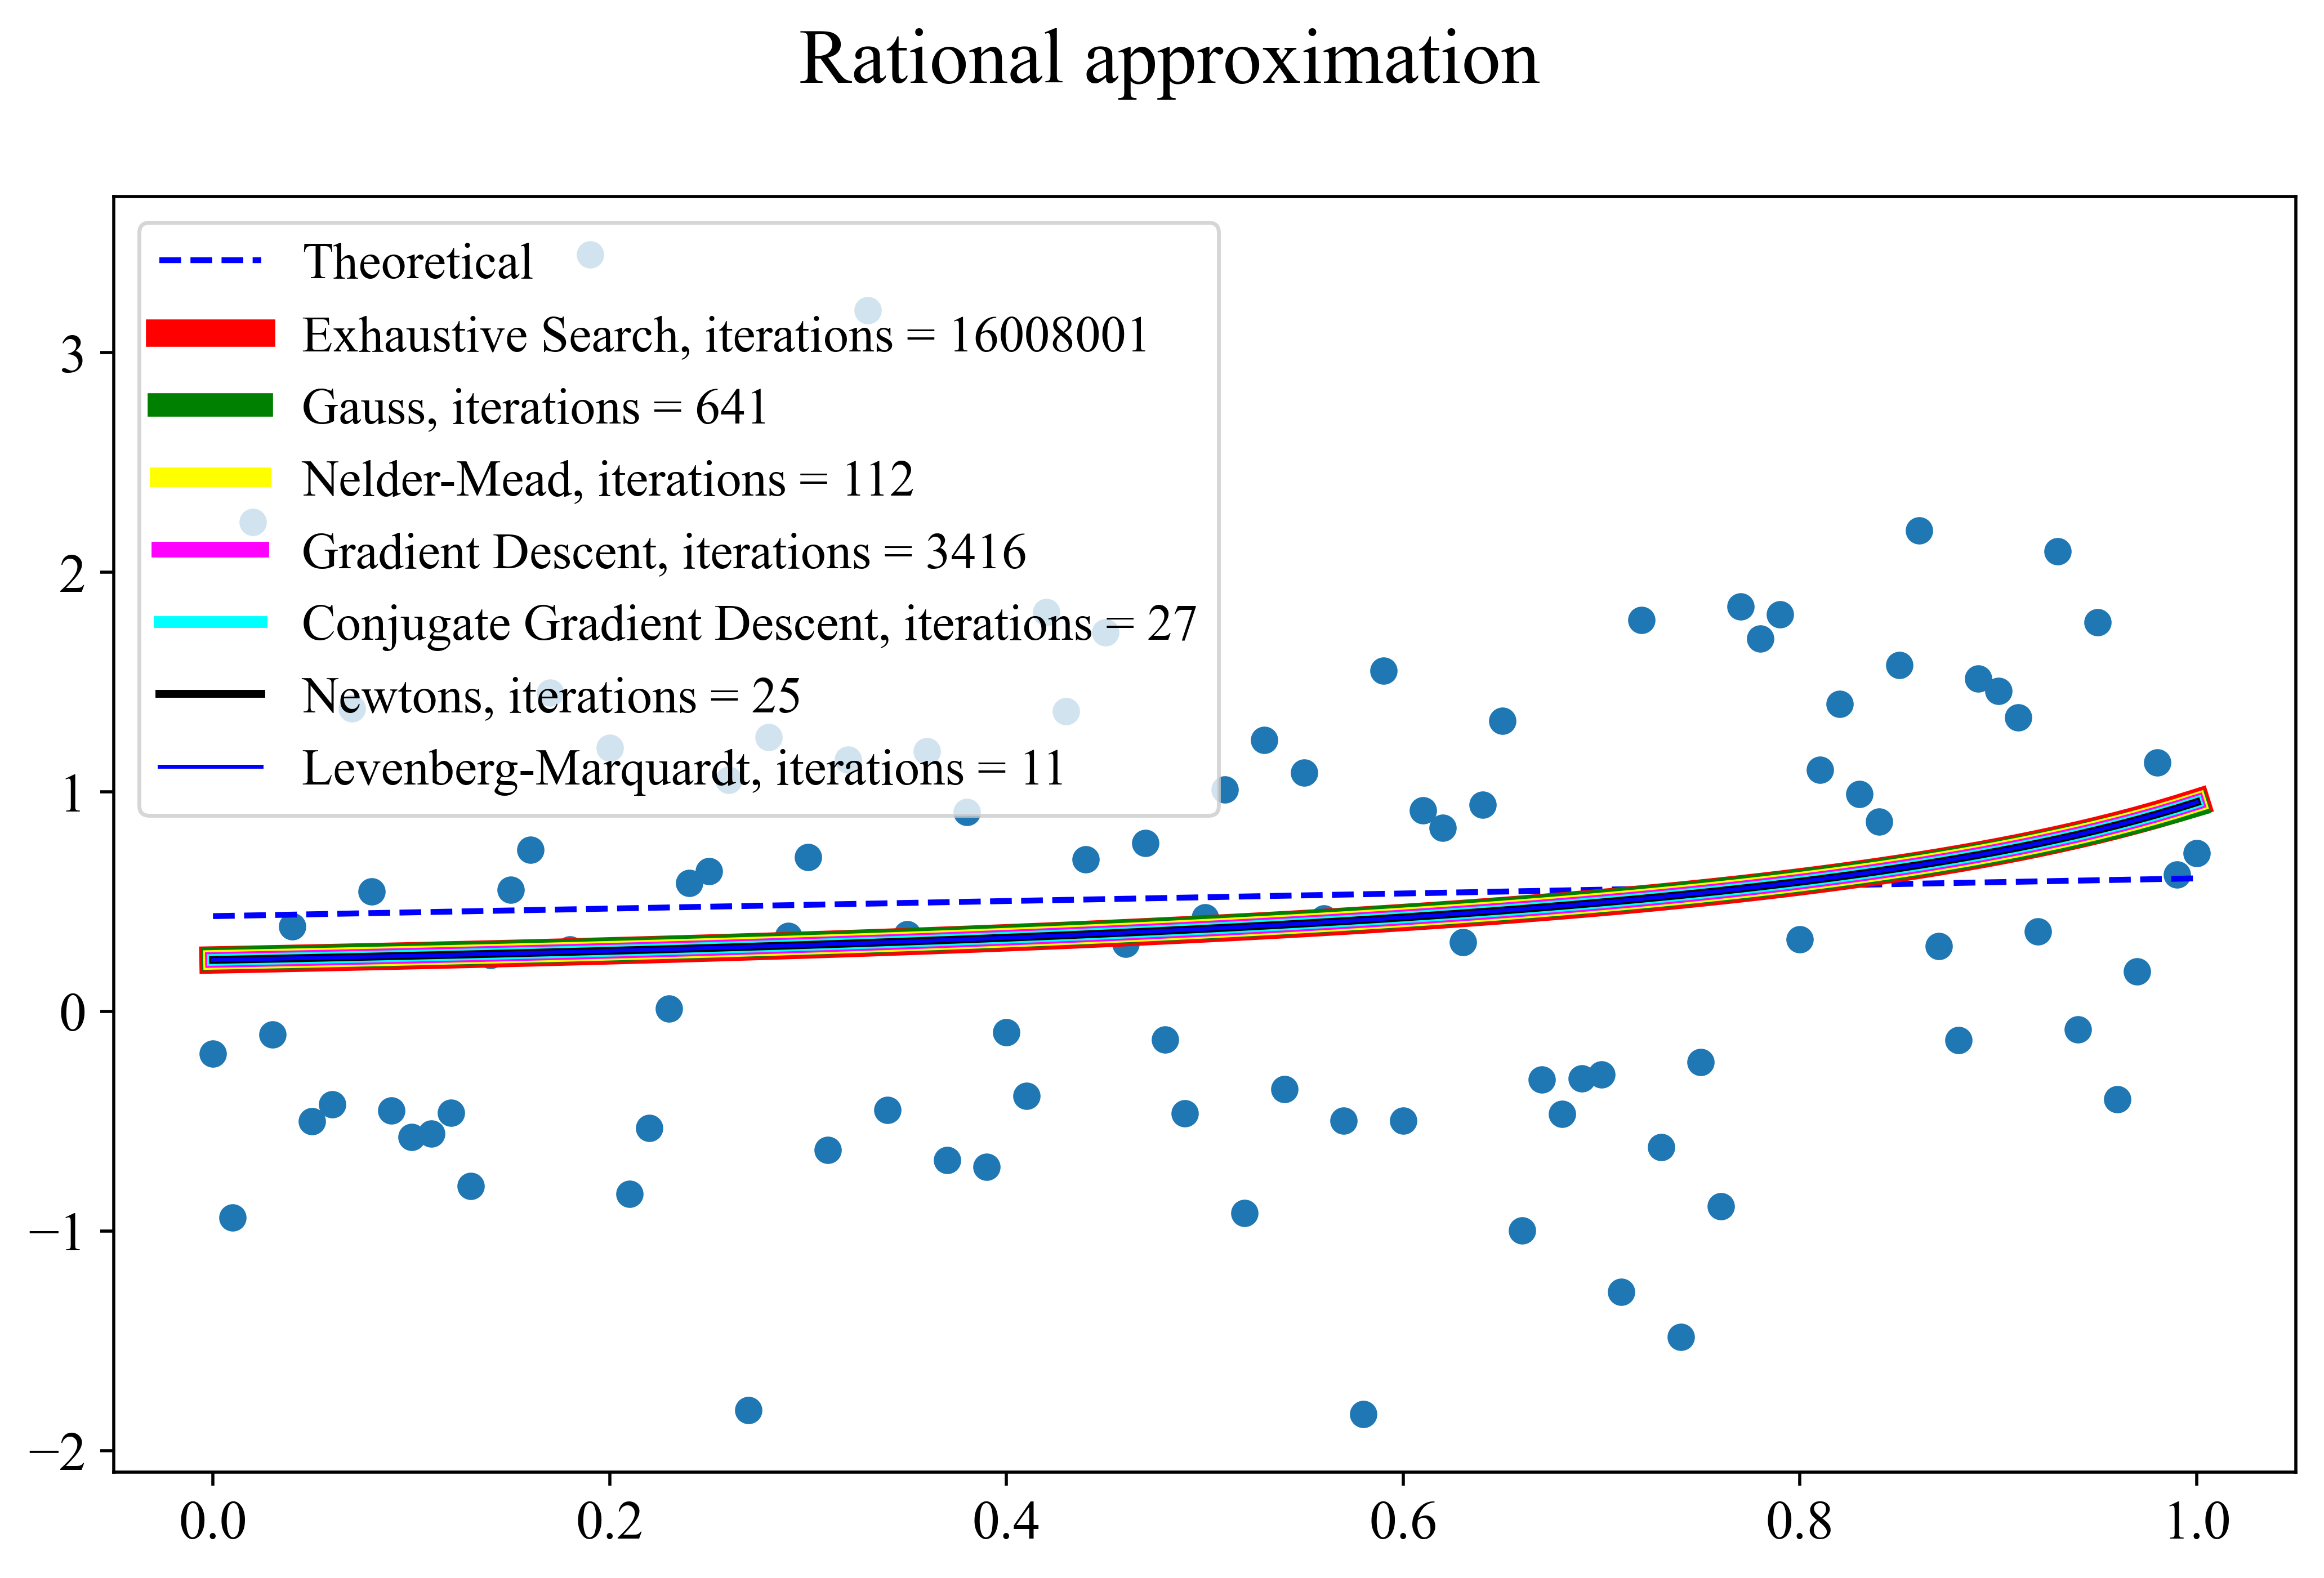

In [29]:
plt.figure(dpi=500)
plt.scatter(opt_data['X'], opt_data['y'])
plt.plot(opt_data['X'], opt_data['y_k'], c='blue', label='Theoretical',linestyle = '--')
for method, color,linewidth in zip(['exhaustivesearch', 'gauss', 'nelder_mead', 'gd', 'conj_gd', 'newton', 'lm'],
                         ['red', 'green', 'yellow', 'magenta', 'cyan','black','blue'],[7,6,5,4,3,2,1]):
    row = approx[(approx['method'] == method) & (approx['approx_func'] == 'rational')]
    a, b = row['a'].values[0], row['b'].values[0]
    y_pred = rational(opt_data['X'], a, b)
    iters = row['iterations'].values[0]
    plt.plot(opt_data['X'], y_pred, c=color, label=f'{Methods[method]}, iterations = {iters}', linewidth=linewidth)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best',fontsize=13)
plt.suptitle('Rational approximation', fontsize=20)
plt.savefig(fname='Rational approximation.png', format='png')

